In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

from sklearn import metrics

In [2]:
def load_RawData(fn, str_AlgVersion, str_AlgRelease):
    dict_dtypes={'LocationNo': str}
    df = pd.read_csv('BuyTitleOfferEval_{0}_{1}.csv'.format(str_AlgVersion, str_AlgRelease), header=0, dtype=dict_dtypes, index_col=0)   
    df['actual_TotalBuyOffers'] = df['actual_BuyOfferAmt'] * df['count_ItemsPriced']
    df['pred_TotalSuggestedOffers'] = df['pred_SuggestedOffer'] * df['count_ItemsPriced']
    df['error_AAD'] = df['pred_AAD'] - df['avg_CatalogAccDays_TrashPenalty']
    df['RSE_AAD'] = np.sqrt((df['pred_AAD'] - df['avg_CatalogAccDays_TrashPenalty'])**2)
    return df

def remove_ColSuffix(df):
    key = list(df.columns)
    values = [s.replace('_Loc', '') for s in [c.replace('_Chain', '') for c in df.columns]]
    dict_ColNames = dict(zip(key, values))
    df = df.rename(columns=dict_ColNames)
    return df

def prep_DataFrames(df):
    #Set filters for offer types
    filt_LocChain = df['OfferType'] == 'LocChain'
    filt_Chain = df['OfferType'] == 'ChainOnly'
    #Select appropriate columns for specific dataframes
    list_LocCols = [c for c in df.columns if ((c[0:4] != 'pred') or (c[-3:] == 'Loc'))]
    list_ChainCols = [c for c in df.columns if ((c[0:4] != 'pred') or (c[-5:] == 'Chain'))]
    list_LocChainCols = [c for c in df.columns if ((c[:-3] != 'Loc') or (c[-5:] != 'Chain'))]
    #Create specific dataframes
    df_LocChain = df[filt_LocChain][list_LocChainCols]
    df_Chain = df[filt_Chain].dropna(how='all', axis=1)
    #Create specific dataframes and remove identifying column suffixes
    df_Loc = remove_ColSuffix(df[filt_LocChain][list_LocCols])
    df_LocCompChain = remove_ColSuffix(df[filt_LocChain][list_ChainCols])
    return df_LocChain, df_Chain, df_Loc, df_LocCompChain

In [3]:
str_AlgVersion = 'V1'
str_AlgRelease = 'R42'

In [4]:
dict_dtypes={'LocationNo': str}
df = pd.read_csv('BuyTitleOfferEval_{0}_{1}.csv'.format(str_AlgVersion, str_AlgRelease), header=0, dtype=dict_dtypes, index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df['actual_TotalBuyOffers'] = df['actual_BuyOfferAmt'] * df['count_ItemsPriced']
df['pred_TotalSuggestedOffers'] = df['pred_SuggestedOffer'] * df['count_ItemsPriced']
df['error_AAD'] = df['pred_AAD'] - df['avg_CatalogAccDays_TrashPenalty']
df['squarederror_AAD'] = (df['pred_AAD'] - df['avg_CatalogAccDays_TrashPenalty'])**2

In [6]:
# filt_Chain = df['LocationNo'] == 'Chain'
# df_All = create_CombinedOfferDF(df)
# df_Chain = df[filt_Chain]#.reset_index(drop=True)
# df_Loc = df[~filt_Chain]#.reset_index(drop=True)

In [7]:
filt_LocChain = df['OfferType'] == 'LocChain'
filt_Chain = df['OfferType'] == 'ChainOnly'
list_LocCols = [c for c in df.columns if ((c[0:4] != 'pred') or (c[-3:] == 'Loc'))]
list_ChainCols = [c for c in df.columns if ((c[0:4] != 'pred') or (c[-5:] == 'Chain'))]
list_LocChainCols = [c for c in df.columns if ((c[:-3] != 'Loc') or (c[-5:] != 'Chain'))]
df_LocChain = df[filt_LocChain][list_LocChainCols]
df_Chain = df[filt_Chain].dropna(how='all', axis=1)

df_Loc = remove_ColSuffix(df[filt_LocChain][list_LocCols])

df_LocCompChain = remove_ColSuffix(df[filt_LocChain][list_ChainCols])


df_Chain = df_Chain[~df_Chain['pred_AAD'].isna()].reset_index(drop=True)
df_Loc = df_Loc[~df_Loc['pred_BuyOfferPct'].isna()].reset_index(drop=True)

In [8]:
filt_LocNAs = df_Loc['pred_BuyOfferPct'].isna()
filt_ChainNAs = df_Chain['pred_BuyOfferPct'].isna()
print(df_Loc[~filt_LocNAs]['count_ItemsPriced'].sum()/df_Chain[~filt_ChainNAs]['count_ItemsPriced'].sum())
print(df_Loc[~filt_LocNAs]['count_ItemsPriced'].sum())
print(df_LocChain['count_ItemsPriced'].sum())
print(df_LocCompChain['count_ItemsPriced'].sum())

0.2077580418245791
474622
2285658
2285658


In [9]:
df_LocChain

,LocationNo,CatalogID,CatalogBinding,count_ItemsPriced,count_ItemsSold,avg_CatalogAccDays_TrashPenalty,actual_AvgSalePrice,actual_BuyGradeName,actual_BuyOfferPct,actual_BuyOfferAmt,...,pred_AvgSalePrice_Loc,pred_BuyOfferPct_Loc,pred_SuggestedOffer_Loc,pred_AAD_Loc,Date_Generated,OfferType,actual_TotalBuyOffers,pred_TotalSuggestedOffers,error_AAD,squarederror_AAD
0,00011,7430,General,1,1,2.140000,9.99,A,0.40,3.9960,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,3.9960,2.67,28.293462,800.519966
1,00081,8677035,CD,1,1,24.440000,4.99,B,0.30,1.4970,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,1.4970,0.24,172.302083,29688.007921
2,00024,3514905,General,1,1,3.960000,3.00,A,0.40,1.2000,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,1.2000,0.28,287.858636,82862.594529
3,00078,1777060,General,1,1,4.420000,3.99,A,0.40,1.5960,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,1.5960,1.22,13.576763,184.328494
4,00087,3333663,General,1,1,36.720000,6.49,B,0.30,1.9470,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,1.9470,1.18,92.088919,8480.368988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033085,00081,6603265,General,1,1,100.850000,3.00,C,0.20,0.6000,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,0.6000,0.30,166.330938,27665.980770
2033086,00057,12046658,General,1,0,149.950000,NaN,D,0.05,0.4995,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,0.4995,0.47,231.828125,53744.279541
2033087,00033,11045882,General,1,0,97.680000,NaN,C,0.20,NaN,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,NaN,0.50,77.610000,6023.312100
2033088,00033,14618118,General,2,2,66.753333,7.99,C,0.20,1.5980,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,3.1960,6.00,-57.632083,3321.457029


In [10]:
def create_PredCompDF(df, minSampleNum, binding='', **kwargs):
    list_Bindings = df['CatalogBinding'].unique()
    if (binding in list_Bindings) == False:
        binding = list_Bindings
    else: 
        binding = [binding]
    filt_QtyNPlus= (df['count_ItemsPriced'] >= minSampleNum) & (df['CatalogBinding'].isin(binding))
    df_PredCompUngrouped = df[filt_QtyNPlus].reset_index(drop=True)
    df_PredComp = df_PredCompUngrouped.groupby(['pred_BuyOfferPct', 'actual_BuyOfferPct']).sum()[['count_ItemsPriced', 'count_ItemsSold']].reset_index()
    return df_PredComp

def calc_CatAcc(df, gradeThreshold=0, **kwargs):
    filt_EqualGrades = df['pred_BuyOfferPct'] == df['actual_BuyOfferPct']
    filt_GradeThreshold = df['pred_BuyOfferPct'] >= gradeThreshold
    df_AccByGrade = (df[filt_EqualGrades & filt_GradeThreshold]['count_ItemsPriced'].sum() /
                     df[filt_GradeThreshold]['count_ItemsPriced'].sum())
    return df_AccByGrade

def calc_CatAccByGrade(df):
    filt_EqualGrades = df['pred_BuyOfferPct'] == df['actual_BuyOfferPct']
    df_AccByGrade = pd.DataFrame((df[filt_EqualGrades].groupby('pred_BuyOfferPct').sum()['count_ItemsPriced'] /
                     df.groupby('pred_BuyOfferPct').sum()['count_ItemsPriced']))
    df_AccByGrade= df_AccByGrade.merge(df.groupby('pred_BuyOfferPct').sum()['count_ItemsPriced'], on='pred_BuyOfferPct').reset_index()
    df_AccByGrade.rename(columns={'pred_BuyOfferPct': 'Suggested Offer Grade', 'count_ItemsPriced_x': 'Pct Accuracy', 'count_ItemsPriced_y': 'Total Qty'}, inplace=True)
    return df_AccByGrade

def calc_CatPredPctsByGrade(df, gradeThreshold=0, **kwargs):
    df_PredPctsByGrade = df.merge(df.groupby('pred_BuyOfferPct').sum()['count_ItemsPriced'], on='pred_BuyOfferPct')
    df_PredPctsByGrade['pct_ActualGrades'] = df_PredPctsByGrade['count_ItemsPriced_x'] / df_PredPctsByGrade['count_ItemsPriced_y']
    df_PredPctsByGrade.rename(columns={'pred_BuyOfferPct': 'Suggested Offer Grade', 
                                       'actual_BuyOfferPct': 'Actual Grade',
                                       'count_ItemsPriced_x': 'Qty Actual Grades',
                                       'pct_ActualGrades': 'Pct Actual Grades'}, inplace=True)
    filt_GradeThreshold = df_PredPctsByGrade['Suggested Offer Grade'] >= gradeThreshold
    return df_PredPctsByGrade[filt_GradeThreshold][['Suggested Offer Grade', 'Actual Grade', 'Qty Actual Grades', 'Pct Actual Grades']]

def calc_MRSE(pred, targ):
    mrse = np.sqrt(np.mean([((t - p)**2) for (p, t) in zip(pred, targ)]))
    return mrse

In [11]:
#calc_MRSE(df_Chain['avg_CatalogAccDays_NR'], df_Chain['pred_AAD'])

In [12]:
calc_MRSE(df_Chain['avg_CatalogAccDays_TrashPenalty'], df_Chain['pred_AAD'])

848.5027774633654

In [13]:
calc_MRSE(df_Chain['avg_CatalogAccDays_TrashPenalty'], df_Chain['pred_AAD'])

848.5027774633654

In [14]:
filt_Grade = df_Chain['pred_BuyOfferPct'] > 0
filt_QtyThreshold = df_Chain['count_ItemsPriced'] >= 5
filt_Binding = df_Chain['CatalogBinding'] == 'General'

In [15]:
calc_MRSE(df_Chain['avg_CatalogAccDays_TrashPenalty'], 
          df_Chain['pred_AAD'])

848.5027774633654

In [16]:
calc_MRSE(df_Chain[filt_Grade & filt_QtyThreshold]['avg_CatalogAccDays_TrashPenalty'], 
          df_Chain[filt_Grade & filt_QtyThreshold]['pred_AAD'])

120.9473781195262

In [17]:
120.9/400

0.30225

In [18]:
filt_Binding = df_Chain['CatalogBinding'] == 'General'
df_ChainPredComp = create_PredCompDF(df_Chain[filt_Binding], 5)
print(calc_CatAcc(df_ChainPredComp, gradeThreshold=0))
calc_CatAccByGrade(df_ChainPredComp)

0.6528657265265547


,Suggested Offer Grade,Pct Accuracy,Total Qty
0,0.00,0.518143,109356
1,0.05,0.658894,357132
2,0.20,0.746513,460541
3,0.30,0.548545,173315
4,0.40,0.310015,36366


In [19]:
filt_Binding = df_Chain['CatalogBinding'] == 'General'
df_ChainPredComp = create_PredCompDF(df_Chain[filt_Binding], 5)
print(calc_CatAcc(df_ChainPredComp, gradeThreshold=0))
calc_CatAccByGrade(df_ChainPredComp)

0.6528657265265547


,Suggested Offer Grade,Pct Accuracy,Total Qty
0,0.00,0.518143,109356
1,0.05,0.658894,357132
2,0.20,0.746513,460541
3,0.30,0.548545,173315
4,0.40,0.310015,36366


In [20]:
calc_CatPredPctsByGrade(df_ChainPredComp, gradeThreshold=0)

,Suggested Offer Grade,Actual Grade,Qty Actual Grades,Pct Actual Grades
0,0.00,0.00,56662,0.518143
1,0.00,0.05,48513,0.443624
2,0.00,0.20,4112,0.037602
3,0.00,0.30,64,0.000585
4,0.00,0.40,5,0.000046
5,0.05,0.00,29524,0.082670
6,0.05,0.05,235312,0.658894
7,0.05,0.20,89784,0.251403
8,0.05,0.30,2406,0.006737
9,0.05,0.40,106,0.000297


In [21]:
filt_actual = df_Chain['actual_BuyOfferPct'] == 0.4
filt_pred = df_Chain['pred_BuyOfferPct'] == 0.4
filt_accurate = df_Chain['pred_BuyOfferPct'] == df_Chain['actual_BuyOfferPct']

df_Chain[filt_accurate & filt_pred]['count_ItemsPriced'].sum() / df_Chain[filt_pred]['count_ItemsPriced'].sum()

0.34385311948430664

In [22]:
df_LocPredComp = create_PredCompDF(df_Loc, 1)
print(calc_CatAcc(df_LocPredComp, gradeThreshold=0))
calc_CatAccByGrade(df_LocPredComp)

0.34242618336276026


,Suggested Offer Grade,Pct Accuracy,Total Qty
0,0.00,0.169276,22543
1,0.05,0.300829,79590
2,0.10,0.286093,4149
3,0.20,0.298900,172606
4,0.30,0.383205,141222
5,0.40,0.511227,54512


In [23]:
def create_ConfusionMatrix_Normalized(df):
    list_CalcCols = ['count_ItemsPriced', 'pred_BuyOfferPct', 'actual_BuyOfferPct']
    df_calc = df[list_CalcCols].copy().dropna(axis=0)
    df_cm = (df_calc.groupby(['pred_BuyOfferPct', 'actual_BuyOfferPct']).sum()['count_ItemsPriced']/
              df_calc.groupby(['pred_BuyOfferPct']).sum()['count_ItemsPriced'])
    df_cm = df_cm.unstack('actual_BuyOfferPct').stack('actual_BuyOfferPct').sort_index(ascending=False) #Add zeros where nulls result in no index value, sort the index
    idx_order = df_cm.index.levels[0].sort_values(ascending=False)
    array_cm = np.array([np.array(df_cm.loc[i]) for i in idx_order])
    return array_cm, idx_order

def create_ConfusionMatrix(df):
    list_CalcCols = ['count_ItemsPriced', 'pred_BuyOfferPct', 'actual_BuyOfferPct']
    df_calc = df[list_CalcCols].copy().dropna(axis=0)
    df_cm = (df_calc.groupby(['pred_BuyOfferPct', 'actual_BuyOfferPct']).sum()['count_ItemsPriced']/
              df_calc.sum()['count_ItemsPriced'])
    df_cm = df_cm.unstack('actual_BuyOfferPct').stack('actual_BuyOfferPct').sort_index(ascending=False)
    idx_order = df_cm.index.levels[0].sort_values(ascending=False)
    array_cm = np.array([np.array(df_cm.loc[i]) for i in idx_order])
    print('Total accuracy = {:0.2%}'.format(np.trace(array_cm)))
    return array_cm, idx_order

def plot_ConfusionMatrix(cm, max_C = 0, fn = '', **kwargs):
    fig, ax = plt.subplots(figsize=(8,6))
    if max_C == 0:
        max_C = max([i for j in cm for i in j])
    sns.heatmap(cm, cmap = 'bone', vmin=0, vmax=max_C, annot=True, fmt='.1%', ax=ax)
    ax.set_xlabel('Actual Offer %', fontsize=14)
    ax.set_ylabel('Predicted Offer %', fontsize=14)
    ax.set_xticklabels([ '40%', '30%', '20%', '5%', '0%'])
    ax.set_yticklabels(['40%', '30%', '20%', '5%', '0%'])
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.2 * max_C, 0.4 * max_C, 0.6 * max_C, 0.8 * max_C, max_C])
    cbar.set_ticklabels(['{:0.0%}'.format(p) for p in [0, 0.2 * max_C, 0.4 * max_C, 0.6 * max_C, 0.8 * max_C, max_C]])
    if fn != '':
        plt.savefig(fn)
    plt.show()
    return 

In [24]:
filt_QtyThreshold = df_Chain['count_ItemsPriced'] >= 5
filt_Binding = df_Chain['CatalogBinding'] == 'General'

In [25]:
df_ChainPredComp = create_PredCompDF(df_Chain[filt_Binding], 5)
print(calc_CatAcc(df_ChainPredComp, gradeThreshold=0))
calc_CatAccByGrade(df_ChainPredComp)

0.6528657265265547


,Suggested Offer Grade,Pct Accuracy,Total Qty
0,0.00,0.518143,109356
1,0.05,0.658894,357132
2,0.20,0.746513,460541
3,0.30,0.548545,173315
4,0.40,0.310015,36366


In [26]:
sns.set_style('whitegrid')

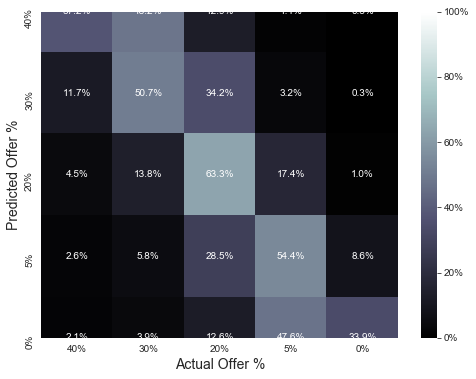

In [27]:
qtyThreshold = 1
filt_ChainQtyThreshold = df_Chain['count_ItemsPriced'] >= qtyThreshold
filt_ChainBinding = df_Chain['CatalogBinding'] == 'General'
cm, pcts = create_ConfusionMatrix_Normalized(df_Chain[filt_ChainBinding & filt_ChainQtyThreshold])
plot_ConfusionMatrix(cm, max_C = 1, fn='{0}ChainAcc_NormConfMatrix_Qty{1}.png'.format(str_AlgRelease, qtyThreshold))

Total accuracy = 65.29%


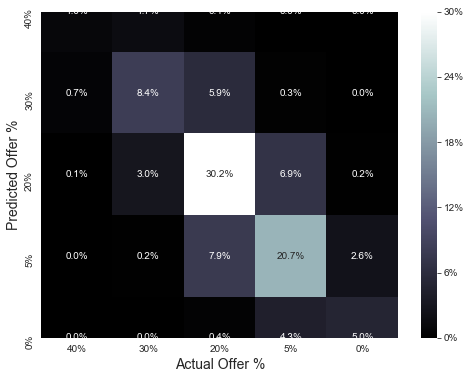

In [28]:
qtyThreshold = 5
filt_ChainQtyThreshold = df_Chain['count_ItemsPriced'] >= qtyThreshold
filt_ChainBinding = df_Chain['CatalogBinding'] == 'General'
cm, pcts = create_ConfusionMatrix(df_Chain[filt_ChainBinding & filt_ChainQtyThreshold])
plot_ConfusionMatrix(cm, fn='{0}ChainAcc_ConfMatrix_Qty{1}.png'.format(str_AlgRelease, qtyThreshold))

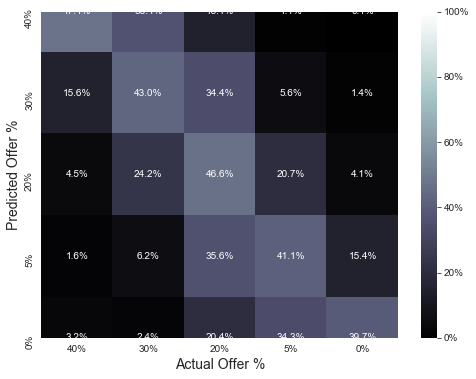

In [29]:
qtyThreshold = 5
filt_LocQtyThreshold = df_Loc['count_ItemsPriced'] >= qtyThreshold
filt_LocBinding = df_Loc['CatalogBinding'] == 'General'
cm, pcts = create_ConfusionMatrix_Normalized(df_Loc[filt_LocBinding & filt_LocQtyThreshold])
plot_ConfusionMatrix(cm, max_C = 1, fn='{0}LocAcc_NormConfMatrix_Qty{1}.png'.format(str_AlgRelease, qtyThreshold))

Total accuracy = 44.76%


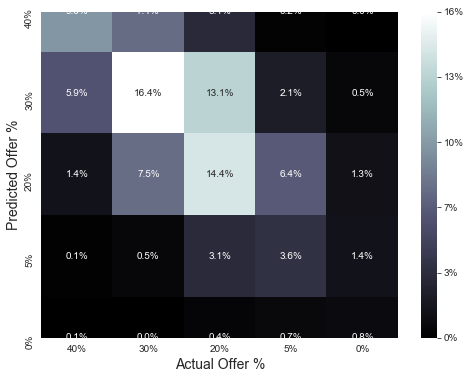

In [30]:
qtyThreshold = 5
filt_LocQtyThreshold = df_Loc['count_ItemsPriced'] >= qtyThreshold
filt_LocBinding = df_Loc['CatalogBinding'] == 'General'
cm, pcts = create_ConfusionMatrix(df_Loc[filt_LocBinding & filt_LocQtyThreshold])
plot_ConfusionMatrix(cm, fn='{0}LocAcc_ConfMatrix_Qty{1}.png'.format(str_AlgRelease, qtyThreshold))

Total accuracy = 43.97%


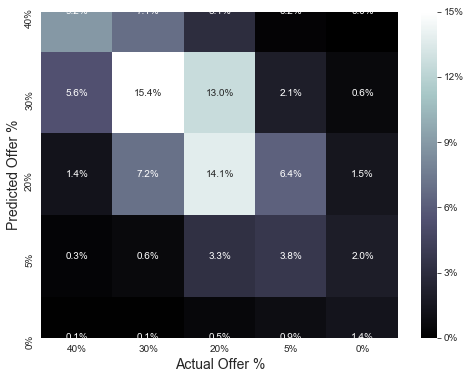

In [31]:
qtyThreshold = 5
filt_LocChainQtyThreshold = df_LocChain['count_ItemsPriced'] >= qtyThreshold
filt_LocChainBinding = df_LocChain['CatalogBinding'] == 'General'
filt_LocChainOffer = df_LocChain['OfferType'] == 'Chain'
cm, pcts = create_ConfusionMatrix(df_LocChain[filt_LocChainBinding & filt_LocChainQtyThreshold])
plot_ConfusionMatrix(cm, fn='{0}LocChainAcc_ConfMatrix_Qty{1}.png'.format(str_AlgRelease, qtyThreshold))

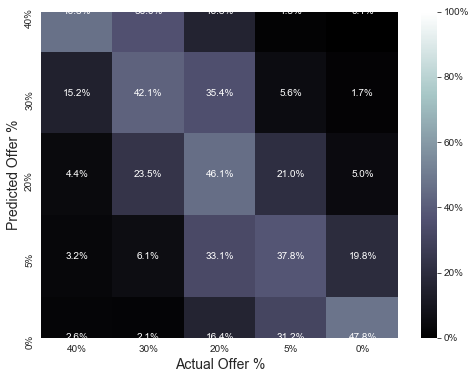

0.024585761730338343


In [32]:
qtyThreshold = 5
filt_LocChainQtyThreshold = df_LocChain['count_ItemsPriced'] >= qtyThreshold
filt_LocChainBinding = df_LocChain['CatalogBinding'] == 'General'
filt_LocChainOffer = df_LocChain['OfferType'] == 'Chain'
cm, pcts = create_ConfusionMatrix_Normalized(df_LocChain[filt_LocChainBinding & filt_LocChainQtyThreshold])
plot_ConfusionMatrix(cm, max_C = 1, fn='{0}LocChainAcc_NormConfMatrix_Qty{1}.png'.format(str_AlgRelease, qtyThreshold))
print(df_LocChain[filt_LocChainBinding & filt_LocChainQtyThreshold]['count_ItemsPriced'].sum()/
      df_LocChain[filt_LocChainBinding]['count_ItemsPriced'].sum())

Total accuracy = 45.27%


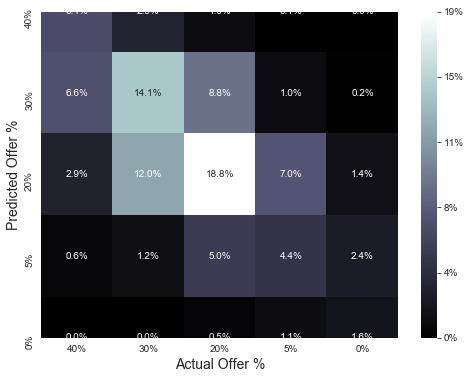

0.024585761730338343


In [33]:
qtyThreshold = 5
filt_LocCompChainQtyThreshold = df_LocCompChain['count_ItemsPriced'] >= qtyThreshold
filt_LocCompChainBinding = df_LocCompChain['CatalogBinding'] == 'General'
filt_LocCompChainOffer = df_LocCompChain['OfferType'] == 'Chain'
cm, pcts = create_ConfusionMatrix(df_LocCompChain[filt_LocCompChainBinding & filt_LocCompChainQtyThreshold])
plot_ConfusionMatrix(cm, fn='{0}LocCompChainAcc_ConfMatrix_Qty{1}.png'.format(str_AlgRelease, qtyThreshold))
print(df_LocCompChain[filt_LocCompChainBinding & filt_LocCompChainQtyThreshold]['count_ItemsPriced'].sum()/
      df_LocCompChain[filt_LocCompChainBinding]['count_ItemsPriced'].sum())

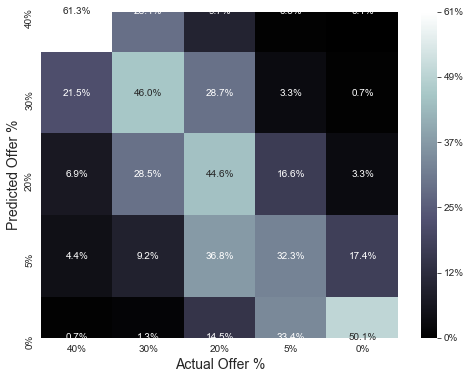

0.024585761730338343


In [34]:
qtyThreshold = 5
filt_LocCompChainQtyThreshold = df_LocCompChain['count_ItemsPriced'] >= qtyThreshold
filt_LocCompChainBinding = df_LocCompChain['CatalogBinding'] == 'General'
filt_LocCompChainOffer = df_LocCompChain['OfferType'] == 'Chain'
cm, pcts = create_ConfusionMatrix_Normalized(df_LocCompChain[filt_LocCompChainBinding & filt_LocCompChainQtyThreshold])
plot_ConfusionMatrix(cm, fn='{0}LocCompChainAcc_ConfMatrix_Qty{1}.png'.format(str_AlgRelease, qtyThreshold))
print(df_LocCompChain[filt_LocCompChainBinding & filt_LocCompChainQtyThreshold]['count_ItemsPriced'].sum()/
      df_LocCompChain[filt_LocCompChainBinding]['count_ItemsPriced'].sum())

In [35]:
print((df_Chain[filt_Binding & filt_QtyThreshold]['actual_BuyOfferAmt'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum())

print((df_Chain[filt_Binding & filt_QtyThreshold]['pred_SuggestedOffer'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum())

print((df_Chain[filt_Binding & filt_QtyThreshold]['actual_BuyOfferAmt'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum() -
     (df_Chain[filt_Binding & filt_QtyThreshold]['pred_SuggestedOffer'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum())

print((df_Chain[filt_Binding & filt_QtyThreshold]['pred_SuggestedOffer'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum()/
     (df_Chain[filt_Binding & filt_QtyThreshold]['actual_BuyOfferAmt'] * 
      df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum())

1224664.6411000001
1311076.25
-86411.60889999988
1.070559405407822


In [36]:
df_Chain[filt_Binding].groupby('pred_BuyOfferPct')['actual_TotalBuyOffers', 'pred_TotalSuggestedOffers'].sum()

,actual_TotalBuyOffers,pred_TotalSuggestedOffers
pred_BuyOfferPct,,
0.00,105726.109100,0.00
0.05,403843.923390,176380.45
0.20,929903.810015,968462.42
0.30,574687.701705,675593.18
0.40,164958.465600,235712.79


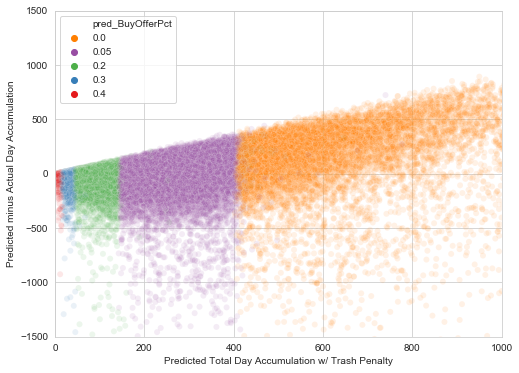

In [37]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(df_Chain[filt_Binding & filt_QtyThreshold]['pred_AAD'],
            df_Chain[filt_Binding & filt_QtyThreshold]['error_AAD'],
            hue=df_Chain[filt_Binding & filt_QtyThreshold]['pred_BuyOfferPct'].astype(str),
            palette=sns.color_palette("Set1", 5)[::-1],
            alpha=0.1)
ax.set_xlim([0,1000])
ax.set_ylim([-1500,1500])
ax.set_xlabel('Predicted Total Day Accumulation w/ Trash Penalty')
ax.set_ylabel('Predicted minus Actual Day Accumulation')
#plt.savefig('./R42_ContinuousErrorRegPlot.png')
plt.show()

In [38]:
df_LocChain

,LocationNo,CatalogID,CatalogBinding,count_ItemsPriced,count_ItemsSold,avg_CatalogAccDays_TrashPenalty,actual_AvgSalePrice,actual_BuyGradeName,actual_BuyOfferPct,actual_BuyOfferAmt,...,pred_AvgSalePrice_Loc,pred_BuyOfferPct_Loc,pred_SuggestedOffer_Loc,pred_AAD_Loc,Date_Generated,OfferType,actual_TotalBuyOffers,pred_TotalSuggestedOffers,error_AAD,squarederror_AAD
0,00011,7430,General,1,1,2.140000,9.99,A,0.40,3.9960,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,3.9960,2.67,28.293462,800.519966
1,00081,8677035,CD,1,1,24.440000,4.99,B,0.30,1.4970,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,1.4970,0.24,172.302083,29688.007921
2,00024,3514905,General,1,1,3.960000,3.00,A,0.40,1.2000,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,1.2000,0.28,287.858636,82862.594529
3,00078,1777060,General,1,1,4.420000,3.99,A,0.40,1.5960,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,1.5960,1.22,13.576763,184.328494
4,00087,3333663,General,1,1,36.720000,6.49,B,0.30,1.9470,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,1.9470,1.18,92.088919,8480.368988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033085,00081,6603265,General,1,1,100.850000,3.00,C,0.20,0.6000,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,0.6000,0.30,166.330938,27665.980770
2033086,00057,12046658,General,1,0,149.950000,NaN,D,0.05,0.4995,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,0.4995,0.47,231.828125,53744.279541
2033087,00033,11045882,General,1,0,97.680000,NaN,C,0.20,NaN,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,NaN,0.50,77.610000,6023.312100
2033088,00033,14618118,General,2,2,66.753333,7.99,C,0.20,1.5980,...,NaN,NaN,NaN,NaN,2019-04-01,LocChain,3.1960,6.00,-57.632083,3321.457029


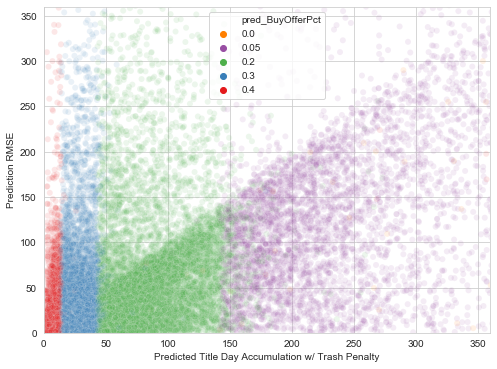

34432


In [39]:
filt_QtyThreshold = df_LocChain['count_ItemsPriced'] >= 3
filt_Binding = df_LocChain['CatalogBinding'] == 'General'
filt_All = filt_QtyThreshold & filt_Binding #
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
            x=df_LocChain[filt_All]['pred_AAD'],
            y=np.sqrt(df_LocChain[filt_All]['squarederror_AAD']),
            hue=df_LocChain[filt_All]['pred_BuyOfferPct'].astype(str),
            palette=sns.color_palette("Set1", 5)[::-1],
            alpha = 0.1)
ax.set_xlim([0,360])
ax.set_ylim([0,360])
ax.set_xlabel('Predicted Title Day Accumulation w/ Trash Penalty')
ax.set_ylabel('Prediction RMSE')
#plt.savefig('./R42_ContinuousRSERegPlot.png')
plt.show()
print(df_LocChain[filt_All]['pred_AAD'].count())

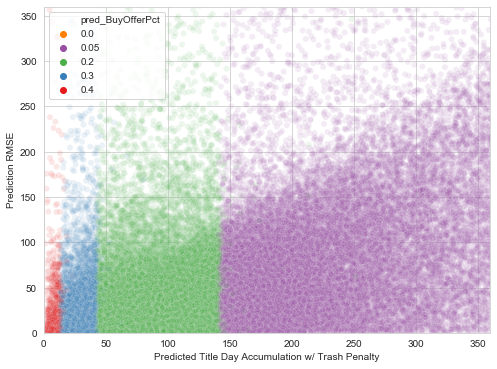

In [40]:
filt_QtyThreshold = df_Chain['count_ItemsPriced'] >= 5
filt_Binding = df_Chain['CatalogBinding'] == 'General'
filt_PredNAs = ~df_Chain['pred_BuyOfferPct'].isna()
filt_Inaccurate = df_Chain['pred_BuyOfferPct'] != df_Chain['actual_BuyOfferPct']
filt_All = filt_QtyThreshold & filt_Binding & filt_PredNAs #& filt_Inaccurate
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
            x=df_Chain[filt_All]['pred_AAD'],
            y=np.sqrt(df_Chain[filt_All]['squarederror_AAD']),
            hue=df_Chain[filt_All]['pred_BuyOfferPct'].astype(str),
            palette=sns.color_palette("Set1", 5)[::-1],
            alpha = 0.1)
ax.set_xlim([0,360])
ax.set_ylim([0,360])
ax.set_xlabel('Predicted Title Day Accumulation w/ Trash Penalty')
ax.set_ylabel('Prediction RMSE')
#plt.savefig('./R42_ContinuousRSERegPlot.png')
plt.show()

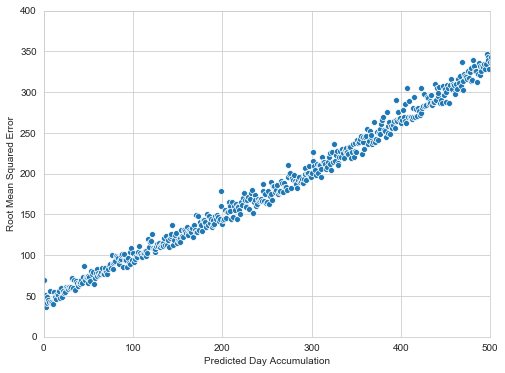

In [41]:
df_plt = df_Chain[filt_Binding][['pred_AAD', 'squarederror_AAD', 'pred_BuyOfferPct']]
df_plt['pred_AAD'] = round(df_plt['pred_AAD'], 0)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(df_plt.groupby('pred_AAD')['pred_AAD'].mean(),
                np.sqrt(df_plt.groupby('pred_AAD')['squarederror_AAD'].mean()),
                ax = ax)
ax.set_xlim([0, 500])
ax.set_ylim([0, 400])
ax.set_xlabel('Predicted Day Accumulation')
ax.set_ylabel('Root Mean Squared Error')
#plt.savefig('./R42_ContinuousRMSE_500Scale.png')
plt.show()

In [42]:
np.sqrt(df_Chain.groupby('pred_BuyOfferPct')['squarederror_AAD'].mean())

pred_BuyOfferPct
0.00    1645.047716
0.05     211.174213
0.10      90.955662
0.20      99.168032
0.30      65.730406
0.40      54.588279
Name: squarederror_AAD, dtype: float64

In [43]:
sns.set_style('whitegrid')

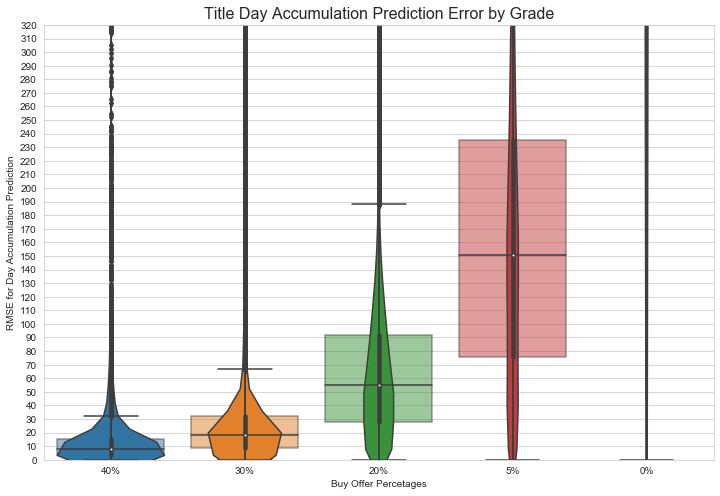

In [44]:
filt_ChainQtyThreshold = df_Chain['count_ItemsPriced'] >= 5
filt_ChainBinding = df_Chain['CatalogBinding'] == 'General'
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x=df_Chain[filt_Binding]['pred_BuyOfferPct'], y=np.sqrt(df_Chain[filt_Binding]['squarederror_AAD']), order=[0.4, 0.3, 0.2, 0.05, 0.0], ax=ax, boxprops=dict(alpha=.5))
sns.violinplot(x=df_Chain[filt_Binding]['pred_BuyOfferPct'], y=np.sqrt(df_Chain[filt_Binding]['squarederror_AAD']), order=[0.4, 0.3, 0.2, 0.05, 0.0], ax=ax)
ax.set_ylim(0,320)
ax.set_xlabel('Buy Offer Percetages')
ax.set_xticklabels([ '40%', '30%', '20%', '5%', '0%'])
ax.set_ylabel('RMSE for Day Accumulation Prediction')
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
#plt.savefig('./R42_ErrorsByGrade_VioBox.png')
ax.set_title('Title Day Accumulation Prediction Error by Grade', fontsize=16)
plt.savefig('./{}_PredErrorByGrade.png'.format(str_AlgRelease))
plt.show()

In [45]:
60/(180-91)

0.6741573033707865

In [46]:
df_Chain[filt_Binding][['actual_BuyOfferPct', 'squarederror_AAD']]

,actual_BuyOfferPct,squarederror_AAD
0,0.20,18596.069803
1,0.40,2687.483677
2,0.00,145260.839161
3,0.00,8747.486784
4,0.30,87.540362
...,...,...
613509,0.40,225.512792
613510,0.30,25157.396451
613511,0.20,201.580553
613512,0.05,41968.643906


In [47]:
(df_Chain.groupby(['pred_BuyOfferPct', 'actual_BuyOfferPct']).sum()['count_ItemsPriced']/
 df_Chain.groupby(['pred_BuyOfferPct']).sum()['count_ItemsPriced']).sort_values(ascending=False)

pred_BuyOfferPct  actual_BuyOfferPct
0.10              0.10                  0.576689
0.20              0.20                  0.559685
0.40              0.30                  0.469592
0.05              0.05                  0.465881
0.30              0.30                  0.455104
0.00              0.05                  0.427083
                  0.00                  0.389781
0.40              0.40                  0.343853
0.30              0.20                  0.328071
0.05              0.20                  0.236428
0.10              0.30                  0.199169
0.05              0.00                  0.166987
0.20              0.05                  0.150603
0.10              0.05                  0.144515
0.40              0.20                  0.142123
0.20              0.30                  0.121260
0.00              0.20                  0.111954
0.30              0.40                  0.107798
0.20              0.10                  0.092614
0.30              0.10          